<a href="https://colab.research.google.com/github/vennela-sai/spiritualchatbot/blob/main/Spiritual_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Required Libraries
This cell installs the necessary libraries for the project:
- **faiss-cpu**: A library for efficient similarity search and clustering of dense vectors.
- **transformers**: Hugging Face's library for state-of-the-art machine learning models, including natural language processing.
- **sentence-transformers**: A library for sentence embedding generation using pre-trained transformer models.


In [ ]:
pip install faiss-cpu transformers sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 47.6 MB/s eta 0:00:00


# Authenticate with Hugging Face Hub
This cell imports the `login` function from the `huggingface_hub` package and logs into the Hugging Face Hub using your personal access token. This step is required to access models and datasets hosted on the Hugging Face platform.

Replace `"your hugging face key"` with your actual access token to authenticate successfully.


In [ ]:
from huggingface_hub import login
login("your hugging face key")


# Install Gradio
This cell installs the **Gradio** library, which is used to create interactive web interfaces for machine learning models. Gradio enables easy testing and sharing of models with a user-friendly graphical interface.


In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


# Install and Import Libraries, Prepare Dataset, and Train Model
- Install required libraries: `optimum`, `auto-gptq`, `transformers`, `torch`, and others.
- Import modules for training and preprocessing.
- Define a function to load and format the dataset for causal language modeling.
- Load the dataset and initialize the tokenizer.
- Configure and load the quantized model using GPTQ.
- Prepare the model for LoRA fine-tuning.
- Set up training arguments and configurations.
- Initialize the `SFTTrainer` and start training.


In [ ]:
!pip install optimum==1.12.0
!pip install auto-gptq==0.4.0
!pip install optimum
!pip install auto-gptq
!pip install --upgrade optimum auto-gptq
!pip install optimum auto-gptq
!pip install transformers
!pip install torch

! pip install accelerate peft bitsandbytes git+https://github.com/huggingface/transformers trl py7zr auto-gptq optimum
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, TrainingArguments
from trl import SFTTrainer, SFTConfig
import os
import pandas as pd

def prepare_dataset(file_path):
    """
    Load dataset from a CSV file and format it for training
    Expected CSV columns: 'Instruct', 'Output'
    """
    data_df = pd.read_csv(file_path)

    # Take first 5000 rows (remove if you want to use full dataset)
    data_df = data_df[:5000]

    # Format the text in the required format
    data_df['Instruct'] = data_df['Instruct'].fillna('').astype(str)
    data_df['Output'] = data_df['Output'].fillna('').astype(str)

    # Format the text in the required format
    data_df["text"] = data_df.apply(
        lambda x: "###Human: " + x["Instruct"] + " ###Assistant: " + x["Output"],
        axis=1
    )

    # Convert to Hugging Face Dataset format
    data = Dataset.from_pandas(data_df)
    return data

# Load and prepare the dataset
dataset_path = "/content/drive/MyDrive/spritualchatbot/data/split_mental_health_dataset.csv"
data = prepare_dataset(dataset_path)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Setup quantization config with updated parameters
quantization_config_loading = GPTQConfig(
    bits=4,
    use_exllama=True,
    exllama_config={"version": 1},
    tokenizer=tokenizer
)

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ",
    quantization_config=quantization_config_loading,
    device_map="auto"
)

# Prepare model for training
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# Configure LoRA
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)
model = get_peft_model(model, peft_config)

# Setup training arguments
training_arguments = TrainingArguments(
    output_dir="/content/mistralfoelder",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=1,
    max_steps=250,
    fp16=True,
    push_to_hub=True
)
sft_config = SFTConfig(
    output_dir="/content/mistralfoelder",  # Added output_dir
    max_seq_length=512,
    packing=False,
    dataset_text_field="text"
)

# Initialize trainer with parameters directly
trainer = SFTTrainer(
    model=model,
    train_dataset=data,
    peft_config=peft_config,
    args=training_arguments,
    tokenizer=tokenizer,
    max_seq_length=512,
    dataset_text_field="text",
    packing=False
)

# Start training
trainer.train()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 re

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.However, loading attributes (e.g. ['use_cuda_fp16', 'use_exllama', 'max_input_length', 'exllama_config', 'disable_exllama']) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:5005: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.1-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_seq_length, dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:300: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:328: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/2006 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 37


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
100,1.435600
200,1.187500


TrainOutput(global_step=250, training_loss=1.2780915679931641, metrics={'train_runtime': 2112.7033, 'train_samples_per_second': 0.947, 'train_steps_per_second': 0.118, 'total_flos': 506963228295168.0, 'train_loss': 1.2780915679931641, 'epoch': 0.9960159362549801})

# Build a Spiritual Chatbot with Gradio and RAG Pipeline
1. **Load Documents**: Specify paths to spiritual and mental health-related documents.
2. **Create FAISS Index**: Use SentenceTransformer to generate embeddings and build a FAISS index for document retrieval.
3. **Define Retrieval Function**: Retrieve top-k relevant documents for a given query based on embeddings.
4. **Load Model**: Load fine-tuned causal language model and tokenizer for generating responses.
5. **Define RAG Pipeline**: Combine retrieved documents with user queries to generate context-aware responses.
6. **Gradio Interface**: Build an interactive chatbot with:
   - A query input box.
   - A response output box.
   - Predefined examples for quick testing.
7. **Launch App**: Share the chatbot for interactive use.


In [ ]:
import gradio as gr
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import torch

# Step 1: Load documents (replace with your actual data paths)
documents = [
    "/content/drive/MyDrive/spiritualchatbotdata/copingstrategiesandspirutality.txt",
    "/content/drive/MyDrive/spiritualchatbotdata/data/meditationstrtegiesdoementalhealthandspiriutalpurposes.txt",
    "/content/drive/MyDrive/spiritualchatbotdata/data/mental_health_guidance.txt",
    "/content/drive/MyDrive/spiritualchatbotdata/data/selfcareandspirutalguidance.txt",
    "/content/drive/MyDrive/spiritualchatbotdata/data/split_mental_health_dataset.csv",
    "/content/drive/MyDrive/spiritualchatbotdata/data/therapyandsprituality.txt"
]
doc_ids = list(range(len(documents)))

# Step 2: Load embeddings and FAISS index
embedder = SentenceTransformer("all-MiniLM-L6-v2")
document_embeddings = embedder.encode(documents, convert_to_tensor=False)
dimension = document_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(document_embeddings))

# Step 3: Define retrieval function
def retrieve_relevant_documents(query, top_k=2):
    query_embedding = embedder.encode([query], convert_to_tensor=False)
    distances, indices = faiss_index.search(np.array(query_embedding), top_k)
    return [(documents[i], distances[0][j]) for j, i in enumerate(indices[0])]

# Step 4: Load the model
tokenizer = AutoTokenizer.from_pretrained("/content/mistralfoelder")
model = AutoModelForCausalLM.from_pretrained("/content/mistralfoelder", torch_dtype=torch.float16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 5: Define the RAG pipeline
def rag_pipeline(query):
    retrieved_docs = retrieve_relevant_documents(query, top_k=2)
    context = " ".join([doc[0] for doc, _ in retrieved_docs])
    input_with_context = f"Context: {context}\n\nQuery: {query}"
    inputs = tokenizer(input_with_context, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=300, temperature=0.01)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    retrieved_texts = "\n".join([f"- {doc} (score: {score:.2f})" for doc, score in retrieved_docs])
    return f"Retrieved Documents:\n{retrieved_texts}\n\nGenerated Response:\n{response}"

# Step 6: Customize Gradio interface with a submit button and improved design
with gr.Blocks(theme="huggingface") as interface:  # Use gr.Blocks for layout control
    gr.Markdown(
        """
        🌺 **Welcome to the Spiritual Chatbot!** 🌺
        Dive into a journey of wisdom and guidance.
        - Ask your questions about spirituality, meditation, mental health, or self-care.
        - This bot retrieves the most relevant information from its knowledge base and provides thoughtful answers.
        🌟 _Feel free to explore the examples or type in your unique queries._ 🌟
        """
    )

    with gr.Row():  # Arrange elements horizontally
        with gr.Column():
            input_box = gr.Textbox(
                lines=3,
                placeholder="Type your question about spirituality, mental health, or self-care here...",
                label="Your Question",
                interactive=True,
            )
        with gr.Column():
            output_box = gr.Textbox(
                lines=10,
                label="Spiritual Chatbot's Response",
                interactive=False,
            )

    submit_btn = gr.Button("Ask the Chatbot 🕉️")
    submit_btn.click(fn=rag_pipeline, inputs=input_box, outputs=output_box)

    gr.Examples(
        examples=[
            "Tell me about meditation.",
            "How can spirituality help with mental health?",
            "What are some coping strategies for stress?",
            "What role does self-care play in spiritual well-being?",
        ],
        inputs=input_box,
    )

# Launch the Gradio app
interface.launch(share=True)


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.1-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.se

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://832575ea07363532d3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.1-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.se

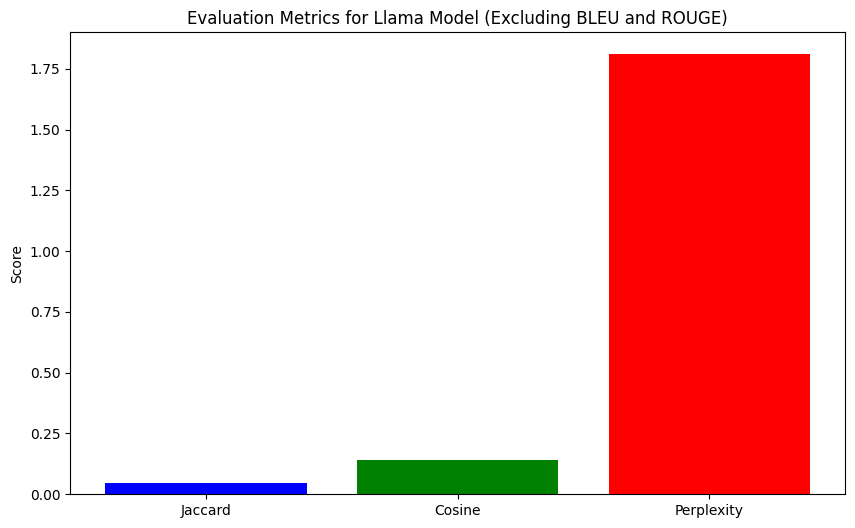

BLEU Score: 8.06798322521923e-232
ROUGE-L Score: 0.13333333333333333


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load Llama model
tokenizer = AutoTokenizer.from_pretrained("/content/mistralfoelder")
model = AutoModelForCausalLM.from_pretrained("/content/mistralfoelder", torch_dtype=torch.float16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Reference and Input
reference_text = "Meditation helps achieve spiritual well-being and mental peace."
input_query = "Tell me how meditation benefits mental health."

# Generate response
inputs = tokenizer(input_query, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=300, temperature=0.01)
generated_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Metrics Calculation
def calculate_metrics(reference, generated):
    # Jaccard Similarity
    ref_set = set(reference.split())
    gen_set = set(generated.split())
    jaccard = len(ref_set.intersection(gen_set)) / len(ref_set.union(gen_set))

    # Cosine Similarity
    ref_vector = tokenizer(reference, return_tensors="pt")['input_ids'].squeeze().numpy()
    gen_vector = tokenizer(generated, return_tensors="pt")['input_ids'].squeeze().numpy()

    # Pad the shorter vector with zeros to match the length of the longer vector
    max_len = max(len(ref_vector), len(gen_vector))
    ref_vector = np.pad(ref_vector, (0, max_len - len(ref_vector)), 'constant')
    gen_vector = np.pad(gen_vector, (0, max_len - len(gen_vector)), 'constant')

    cosine = cosine_similarity([ref_vector], [gen_vector])[0][0]

    # BLEU Score
    bleu = sentence_bleu([reference.split()], generated.split())

    # ROUGE Score
    # Fixed: changed 'rouge-l' to 'rougeL'
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, generated)['rougeL'].fmeasure

    # Perplexity
    inputs = tokenizer(generated, return_tensors="pt").to(device)
    with torch.no_grad():
        loss = model(**inputs, labels=inputs["input_ids"]).loss
    perplexity = torch.exp(loss).item()

    return jaccard, cosine, bleu, rouge_scores, perplexity

# Compute metrics
jaccard, cosine, bleu, rouge_l, perplexity = calculate_metrics(reference_text, generated_response)

# Visualization (excluding BLEU and ROUGE)
metrics = ["Jaccard", "Cosine", "Perplexity"]
scores = [jaccard, cosine, perplexity]

plt.figure(figsize=(10, 6))
plt.bar(metrics, scores, color=["blue", "green", "red"])
plt.title("Evaluation Metrics for Llama Model (Excluding BLEU and ROUGE)")
plt.ylabel("Score")
plt.show()

# Print BLEU and ROUGE scores separately
print(f"BLEU Score: {bleu}")
print(f"ROUGE-L Score: {rouge_l}")


In [ ]:
!pip install nltk rouge-score scikit-learn
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_metrics(reference, generated):
    """
    Calculate evaluation metrics for the generated text.
    """
    # Jaccard Similarity
    ref_set = set(reference.split())
    gen_set = set(generated.split())
    jaccard = len(ref_set.intersection(gen_set)) / len(ref_set.union(gen_set))

    # Cosine Similarity
    # Get token IDs for the entire reference and generated texts
    ref_vector = tokenizer.encode(reference, add_special_tokens=False)
    gen_vector = tokenizer.encode(generated, add_special_tokens=False)

    # Pad the shorter vector to match the length of the longer vector
    max_len = max(len(ref_vector), len(gen_vector))
    ref_vector = np.pad(ref_vector, (0, max_len - len(ref_vector)), 'constant')
    gen_vector = np.pad(gen_vector, (0, max_len - len(gen_vector)), 'constant')

    # Calculate cosine similarity
    cosine = cosine_similarity([ref_vector], [gen_vector])[0][0]

    # BLEU Score (ensure nltk.download('punkt') has been run before)
    nltk.download('punkt', quiet=True) # Download punkt if not already downloaded
    bleu = sentence_bleu([reference.split()], generated.split())

    # ROUGE Score using rouge-score (install with pip install rouge-score)
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(generated, reference)['rougeL'].fmeasure

    # Perplexity
    inputs = tokenizer(generated, return_tensors="pt").to(device)
    with torch.no_grad():
        loss = model(**inputs, labels=inputs["input_ids"]).loss
    perplexity = torch.exp(loss).item()

    return jaccard, cosine, bleu, rouge_scores, perplexity

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=db601332c24d614c9d8ddd82b4737db18812d313805862db19b52b445d53c564
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
